# Contrast Net configurations and evaluate predictions

Once the sweeper of experiments is complete, a number of Nets has been trainned using different values for Learning Rate and receptive field size (patch size manipulated by scaling image size). This section contrasted the produced Nets based on the LOSS function and Accuracy of predictions on the validation set of images. The valition set if a random selection of 5% from the training images used to do premilinary evaluations on the Nets. 

Following the selection of the Net configuration, the selected model is used to predict on the test images. A larger set of images previously separated from the data and contained in the "test" folder. This images are also conprinsing a number of sampling units (e.g., transects) on which to evaluated the error introduced by the machine in estimating the abundance and composition of benthic communities (see paper for details). 

## Select Nets with the best configuration

In [27]:
##SET PATHS 
region='hawaii'
basedir='/media/data_caffe'
import os
import reef_learning.experiments.catlin_caffe_experiments as cce
import reef_learning.deeplearning_wrappers.catlin_classify as cc
import os.path as osp
import warnings
warnings.filterwarnings('ignore')
import reef_learning.deeplearning_wrappers.catlin_caffe_tools as cct
import reef_learning.toolbox.plot_log as pl
import reef_learning.toolbox.beijbom_confmatrix as confmatrix
import reef_learning.toolbox.beijbom_caffe_tools as bct
import reef_learning.deeplearning_wrappers.catlin_tools as ct
from reef_learning.toolbox.beijbom_misc_tools import pload, psave
import matplotlib.pyplot as plt
import glob
import numpy as np
from collections import defaultdict
from itertools import count
from functools import partial


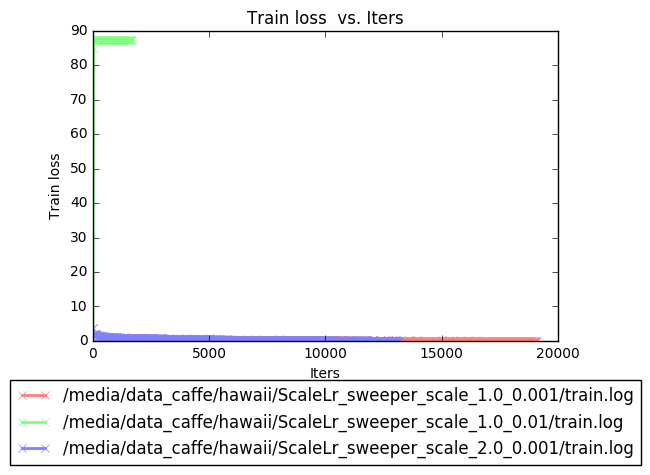

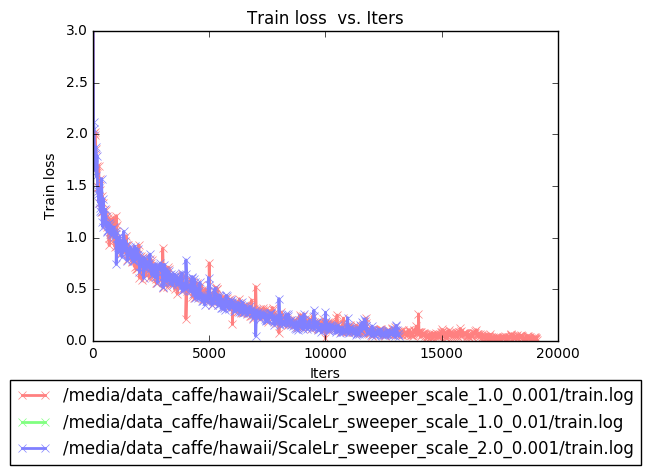

In [2]:
experiment_type='*_sweeper'
% matplotlib inline
# check that the loss/iteration plot reaches a plateau for each experiment
loglist = glob.glob(os.path.join(basedir,region, experiment_type+ "_*/train.log"))

os.chdir(os.path.join(basedir,region))
##Plot all experiments
pl.plot_chart(6, '~/temp.png', loglist)

## Explore the experiments where LOSS is decreasing to find a plateau
pl.plot_chart(6, '~/temp.png', loglist, ylim=[0,3])


## CHECK ACCURACY ON VALIDATION SET 

Here you want to check that the accuracy reached plateau with the iterations. If these two conditions are not met, consider increasing number of iterations


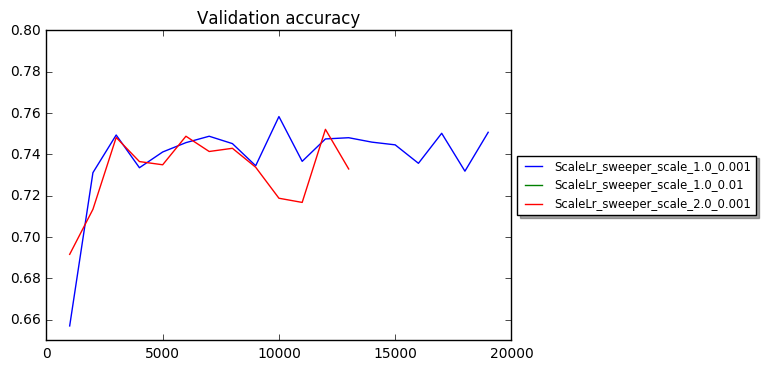

In [3]:
acclist=[]
for ll in loglist:
    bestitt, dd = cct.find_best_iter(osp.dirname(ll))
    acclist.append([osp.basename(osp.dirname(ll)), [d[1] for d in dd if d[0]==bestitt]])
    plt.plot([d[0] for d in dd], [d[1] for d in dd], label=osp.basename(osp.dirname(ll)))

plt.ylim([0.65,0.8])
plt.title('Validation accuracy')
plt.legend(loc='center left', shadow=True, fontsize='small', bbox_to_anchor=(1, 0.5))
plt.show()

In [4]:
from IPython.display import display
import pandas as pd
cols = ['Experiment', 'Accuracy']
df = pd.DataFrame(acclist, columns=cols)
df.apply(pd.to_numeric, errors='ignore')
df['Accuracy'] = df['Accuracy'].str.get(0)
df=df.round(3)
df=df.sort(['Accuracy'], ascending=[0])
display(df)

,Experiment,Accuracy
0,ScaleLr_sweeper_scale_1.0_0.001,0.758
2,ScaleLr_sweeper_scale_2.0_0.001,0.752
1,ScaleLr_sweeper_scale_1.0_0.01,0.001


Having ensure that all Nets reached a stable LOSS and Accuracy, the summary table above display the Accuracy of the best iteraction for each of the experimental Nets. From this table, experiment 0 and 2 are the most suitable Net configurations in terms of learning rate and receptive field size.  

Overall accuracy can be misleading. Sometimes it may be desirable to select a model with a lower accuracy because it has a greater predictive power on an specific problem (e.g., important labels on which to maximise performance). For example, in a problem where there is a large class imbalance, a model can predict the value of the majority class for all predictions and achieve a high classification accuracy, the problem is that this model is not useful in the problem domain. This is called the Accuracy Paradox. For problems like, this additional measures are required to evaluate a classifier.

To contrast these two models in more detail, the following section will use the Nets to predict on a larger set of images and compare their performance to help selecting the model that best suit your needs.

## EVALUATE SELECTED NETS ON TEST IMAGES

NOTES: 
    /This section uses a selected subset of Nets trained in the experiment sweeper based on the results shown above. 
    /This section make use of the GPUs, so make sure that the machine is not in use for training other Nets.

In [ ]:
gpuid=0 #GPU mask
Split='test' # This specifies that the predictions will be done on the images contained in the "test" folder

##Get selected nets from LogList
getVar = lambda searchList, ind: [searchList[i] for i in ind]
selNets=getVar(loglist, [0,2])

# Predict each of the selected Nets on the test images
for workdir in selNets:
    workdir=osp.dirname(workdir)
    # load test-data and write split
    labelset=ct.get_labelset(basedir,region)
    imlist, imdict = ct.load_data(basedir,Split,labelset,region)
    im_mean = bct.calculate_image_mean(imlist[::10])

    # load Net based on the best itteration (bestitt)
    caffemodel = 'snapshot_iter_{}.caffemodel'.format(bestitt)
    net = bct.load_model(workdir, caffemodel, gpuid = gpuid, net_prototxt = 'trainnet.prototxt')
    pyparams = pload(osp.join(workdir, 'trainpyparams.pkl'))

    # run selected Net on test-data
    (gtlist, estlist, scorelist) = bct.classify_from_patchlist(imlist, imdict, pyparams, net)
    psave((gtlist, estlist, scorelist), osp.join(workdir, 'predictions_on_test.p'))

[ 113.0751508   119.7144885   136.96699603]
DataLayer initialized with 417 images, 5 imgs per batch, and 224x224 pixel patches


## Compare Net performance on test images

### Create confusion matrices and calculate performance metrics for each selected Net

In [211]:
cmList_full=[] #list of confusion matrices for the selected Nets using full labelset
cmList_fg=[] #list of confusion matrices for the selected Nets collapsing labels into functional groups
acc_df=pd.DataFrame([]) #Overall performance metrics for selected Nets 
f1_df=pd.DataFrame([]) #F1 score for each label 

for this_exp in selNets:
    this_exp=osp.dirname(this_exp)
    (gtlist, estlist, scorelist) = pload(this_exp+'/predictions_on_test.p')
    ## Create confusion martix for the full labelset
    cm = confmatrix.ConfMatrix(len(labelset), labelset = labelset)
    cm.add(gtlist, estlist)
    #Get Accuracy and Coehn's kappa coefficient for all labels
    (acc, cok) = cm.get_accuracy()
    #Calculate F1 score for all labels
    recalls = cm.get_class_recalls()
    precisions = cm.get_class_precisions()
    f1s_denominator = precisions + recalls
    f1s_denominator[f1s_denominator == 0] = 1
    f1s = 2 * np.multiply(recalls, precisions) / f1s_denominator
    ##Collapse confusion matrix for functional groups
    ct=2 #Column position in the label_sctructure files that defines the classification tier for functional groups
    lines = [line.rstrip() for line in open(osp.join(basedir,region,'label_structure.csv'))][1:]
    labels= [line.split(',')[ct] for line in lines]
    label_to_number = defaultdict(partial(next, count(0)))
    cmap=[(label_to_number[label],label) for label in labels]
    collapsemap=[int(i[0]) for i in cmap]
    collapsemap=np.array(map(int, collapsemap))
    cmc=cm.collapse(collapsemap)
    cmap=set(cmap)
    cmap = sorted(list(cmap), key=lambda tup: tup[0])
    labelsetc = [str(i[1]) for i in cmap]
    cm2= confmatrix.ConfMatrix(len(labelsetc), labelset = labelsetc)
    for x in range(cmc.shape[0]):
        for y in range(cmc.shape[1]):
            cm2.cm[x,y]=cmc[x,y]
    #Calculate F1 score for collapsed labels
    recalls = cm2.get_class_recalls()
    precisions = cm2.get_class_precisions()
    f1s_denominator2 = precisions + recalls
    f1s_denominator2[f1s_denominator2 == 0] = 1
    f1s2 = 2 * np.multiply(recalls, precisions) / f1s_denominator2
    #Get Accuracy and Coehn's kappa coefficient for collapse labels
    (acc2, cok2) = cm2.get_accuracy()
    # Append results to list
    cmList_full.append(cm)
    cmList_fg.append(cm2)
    acc_df=acc_df.append(pd.DataFrame({'Exp':osp.basename(this_exp),
                                       'Type':'All labels',
                                       'Accuracy':acc, 
                                       'k':cok}, index=[0]),ignore_index=True)
    acc_df=acc_df.append(pd.DataFrame({'Exp':osp.basename(this_exp),
                                       'Type':'Functional groups',
                                       'Accuracy':acc2, 
                                       'k':cok2}, index=[0]),ignore_index=True)

    f1_df=f1_df.append(pd.DataFrame.from_dict({'Exp':np.repeat(osp.basename(this_exp),len(cm.labelset)),
                                     'Type':np.repeat('All labels',len(cm.labelset)),
                                     'Labels':cm.labelset,
                                     'F1s':f1s}))
    f1_df=f1_df.append(pd.DataFrame.from_dict({'Exp':np.repeat(osp.basename(this_exp),len(labelsetc)),
                                     'Type':np.repeat('Functional groups',len(labelsetc)),
                                     'Labels':labelsetc,
                                     'F1s':f1s2}))

#### Overal Accuracy and Cohen's kappa coefficient  for full labelset

Cohen's kappa coefficient (k) is a statistic which measures inter-rater agreement for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation (overall accuracy), as κ takes into account the possibility of the agreement occurring by chance.

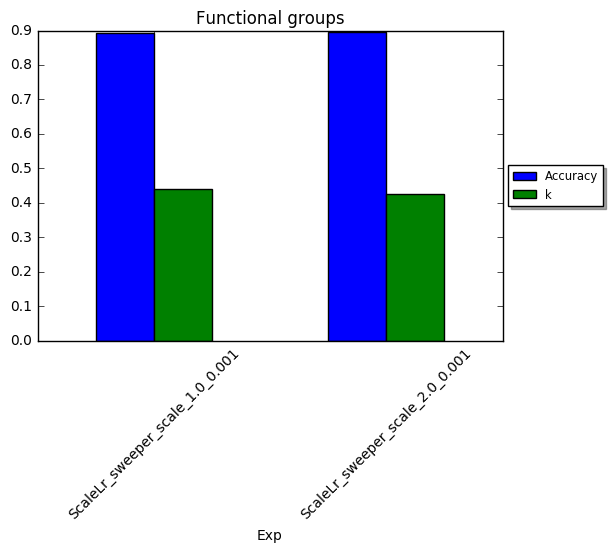

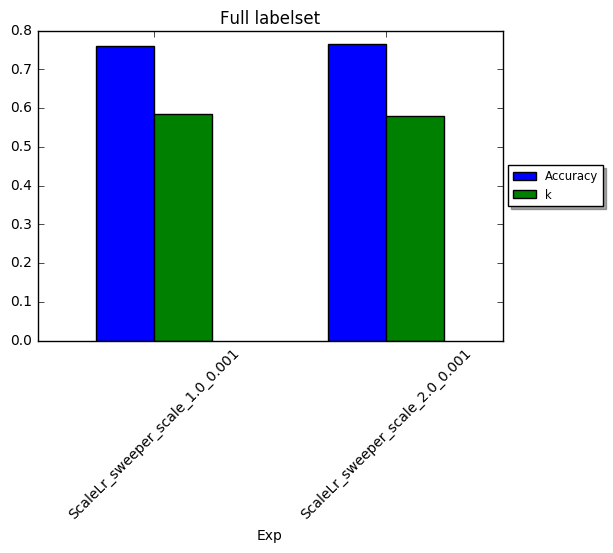

In [134]:
plt=acc_df.loc[acc_df['Type'] == 'Functional groups'].plot.bar(rot=45, x="Exp", title='Functional groups')
plt.legend(loc='center left', shadow=True, fontsize='small', bbox_to_anchor=(1, 0.5))
plt1=acc_df.loc[acc_df['Type'] == 'All labels'].plot.bar(rot=45, x="Exp", title='Full labelset')
plt1.legend(loc='center left', shadow=True, fontsize='small', bbox_to_anchor=(1, 0.5))

#### F1 score for labels 
The F1 Score is the 2*((precision*recall)/(precision+recall)). It is also called the F Score or the F Measure. In other tems, the F1 score conveys the balance between the precision and the recall. Here we compare the selected Nets in terms of F1 score for all the lebels at two different tiers of aggregation:
* Functional groups
* Full labelset 

In [ ]:
##### F1 score on functional groups

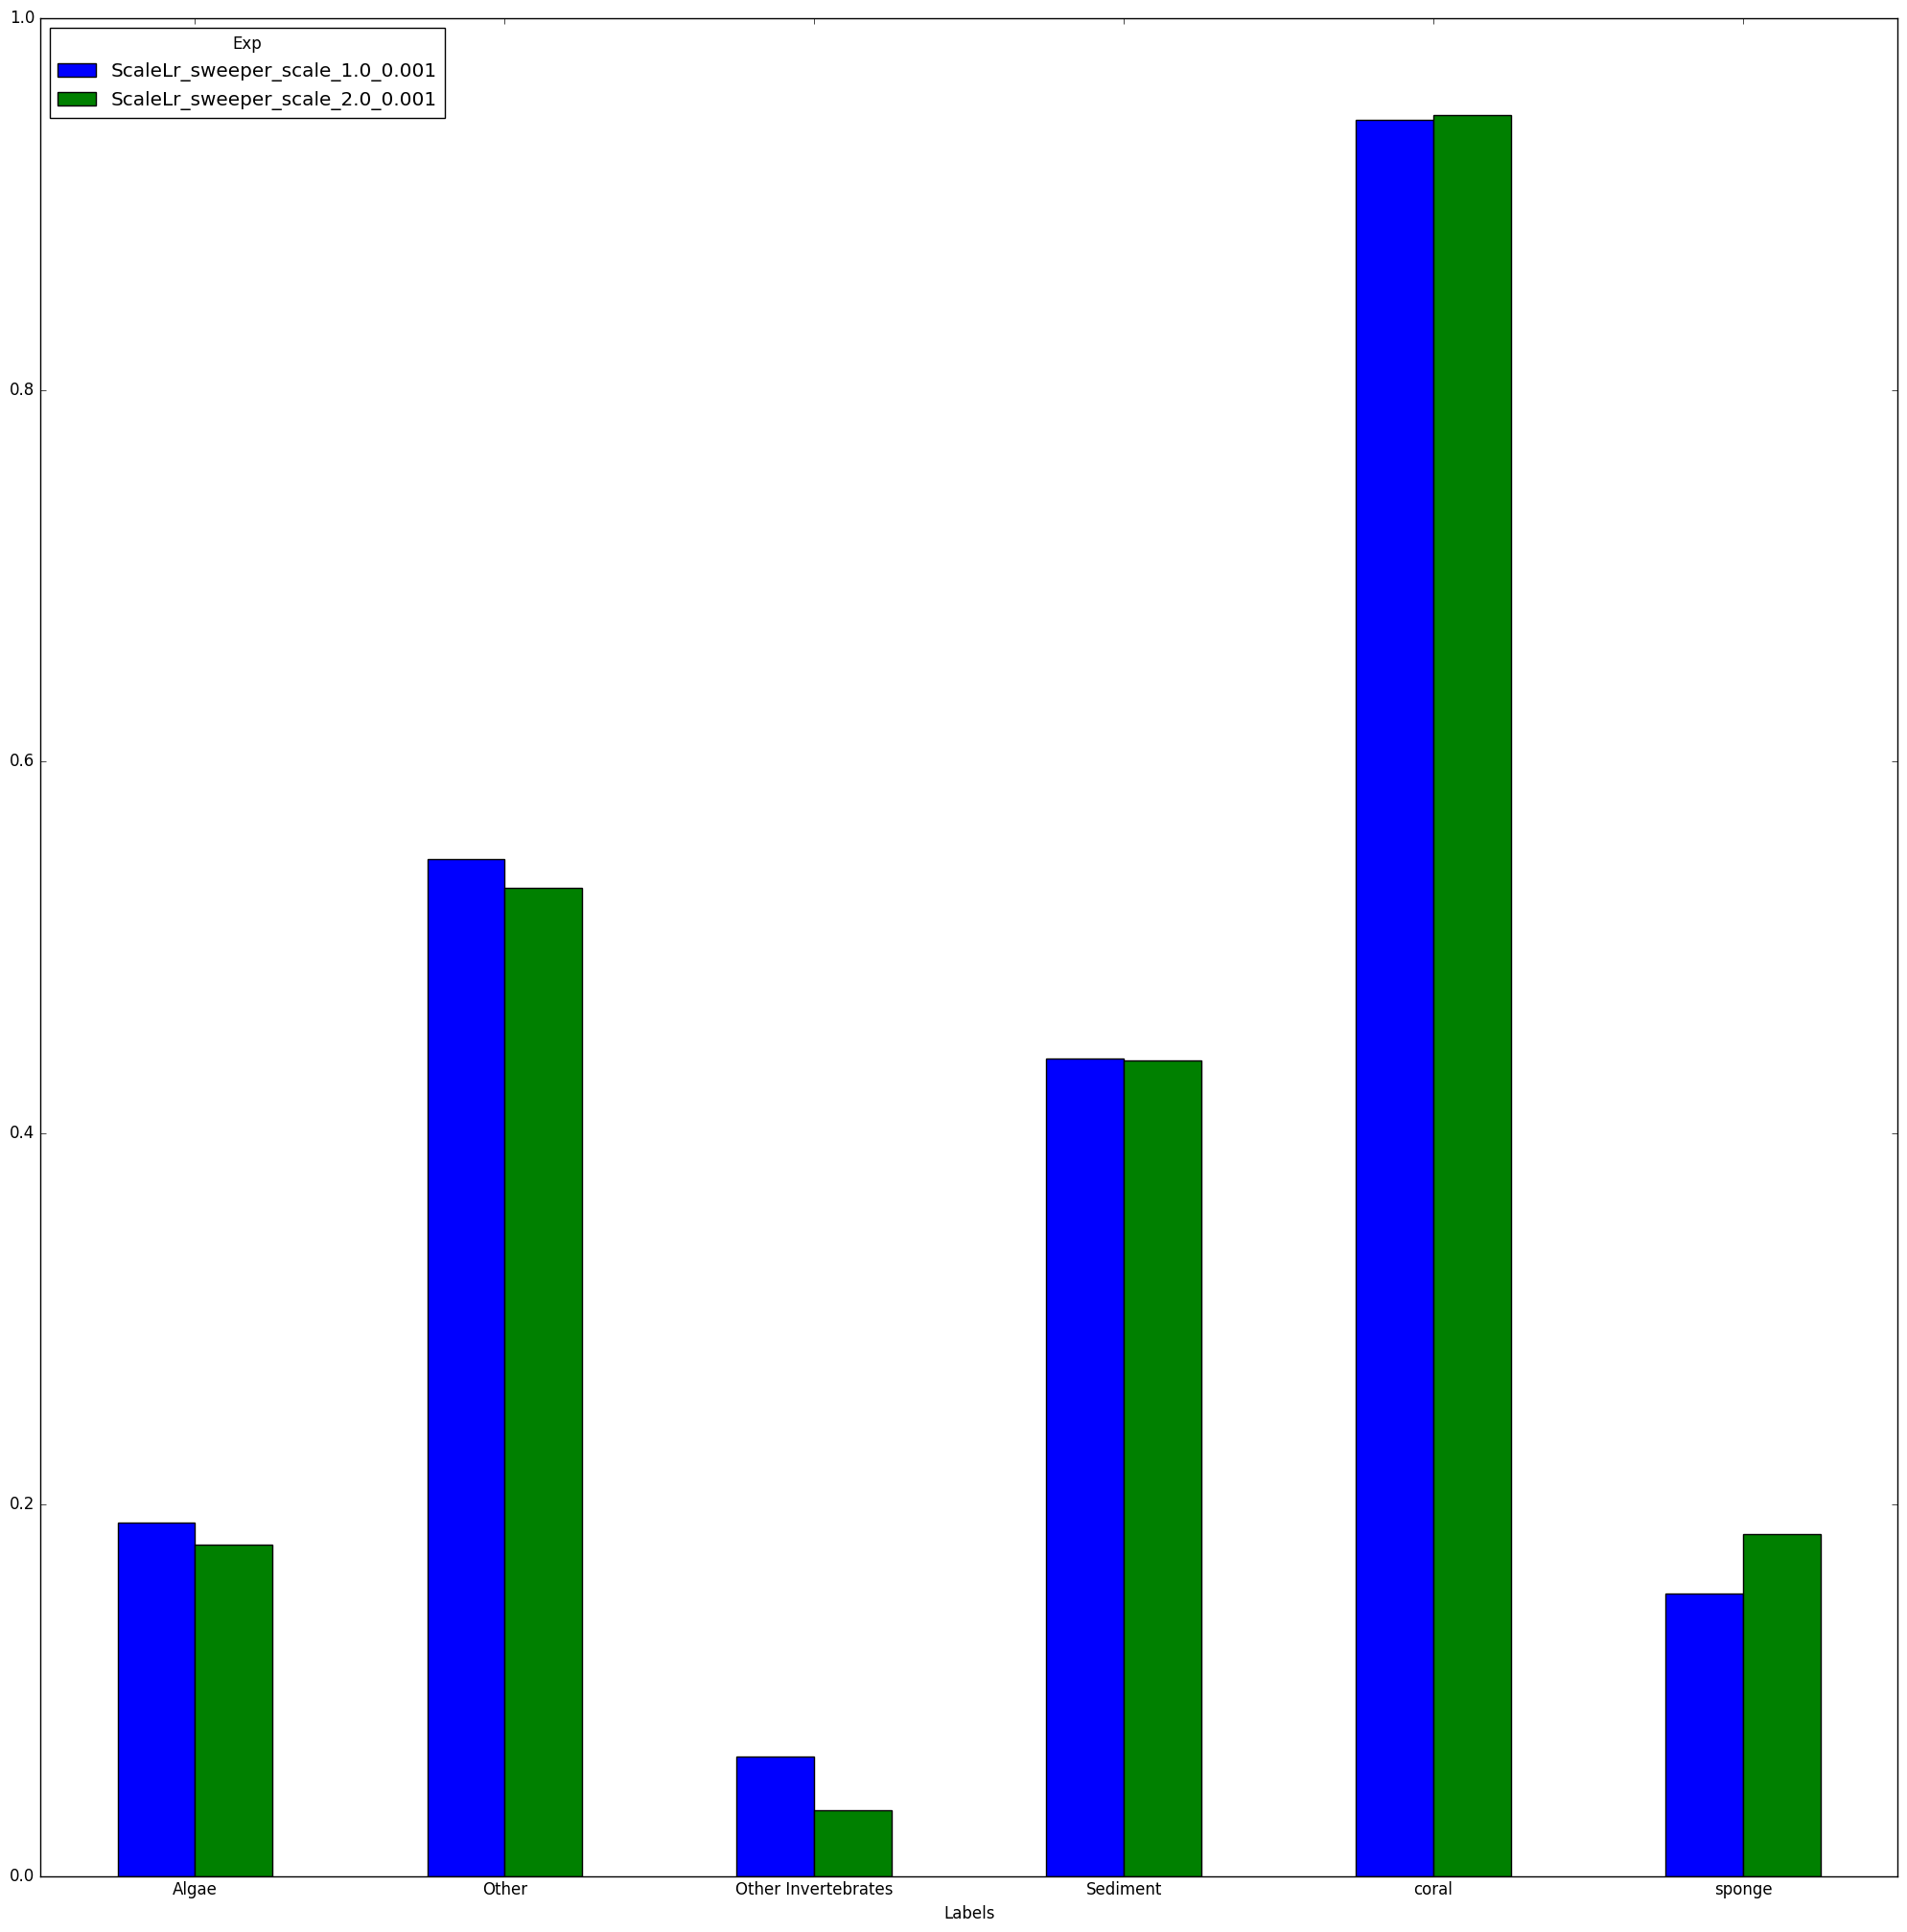

In [195]:
import matplotlib.pyplot as plt
f1_df.loc[f1_df['Type'] == 'Functional groups'].groupby(['Labels', 'Exp'])['F1s'].mean().unstack().plot.bar(rot=0)

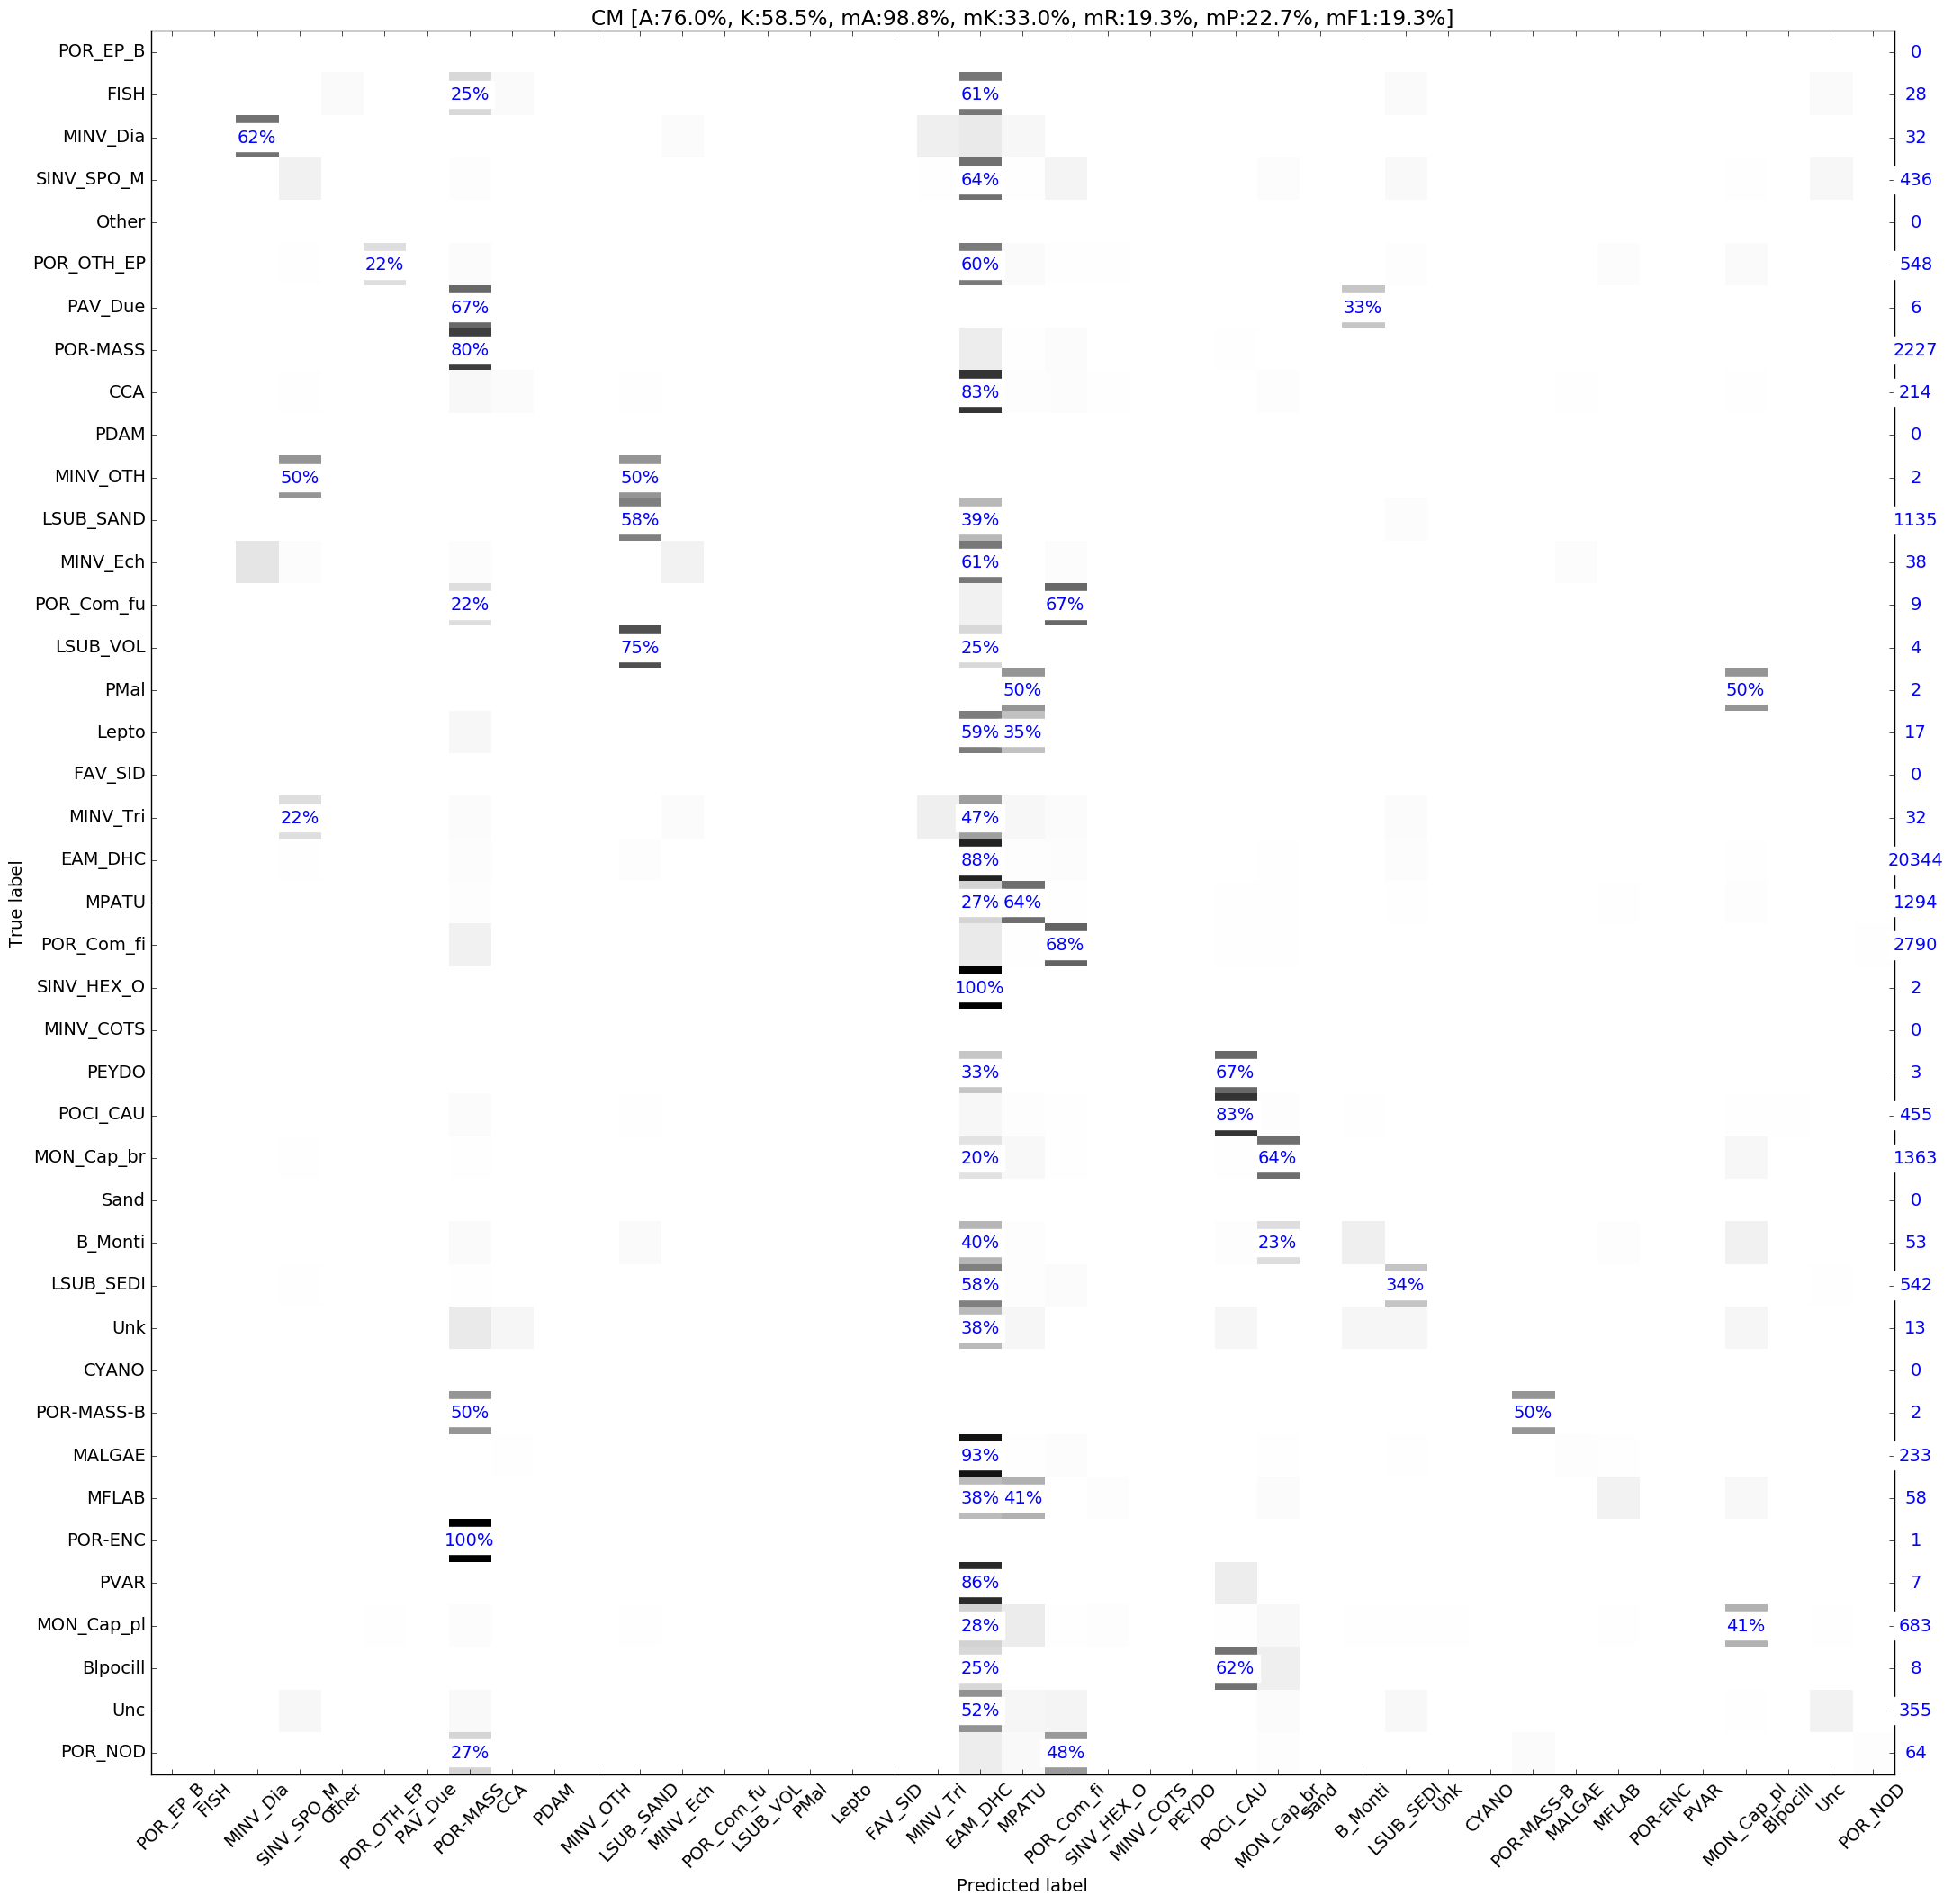

In [206]:
plt.rcParams['figure.figsize'] = 25, 25
cmList_full[0].show(threshold = 20, fontsize=14)

#### Calculate abundance estimation error per sampling units

### Calculate abundance estimation error

In [240]:
df=pd.DataFrame([map(osp.basename, imlist),gtlist, estlist]).T
df.columns=['image','observed','predicted']
display(df)

,image,observed,predicted
0,38045183401.jpg,7,21
1,44018249301.jpg,7,7
2,38016095001.jpg,7,7
3,44009055201.jpg,25,25
4,38025050501.jpg,7,7
5,38008149401.jpg,7,19
6,38007053601.jpg,39,21
7,44013030901.jpg,19,19
8,38006204201.jpg,21,21
9,38008151901.jpg,19,21
